# Simple Moving Average

## Disclaimer

1. This content is intended to be used and must be used for information and education purposes only. It is very important to do your own analysis before making any investment based on your own personal circumstances. You should take independent financial advice from a professional in connection with, or independently research and verify, any information presented below that you wish to rely upon, whether for the purpose of making an investment decision or otherwise.

2. The information provided below is strictly educational for the purpose of learning about securities, investments and market strategies. None of the content presented constitutes - or should be understood as constituting - a recommendation to enter in any securities transactions or to engage in any of the investment strategies presented.


## Investment Warnings

Please note the following important investment warnings.

1. The value of investments and the income derived from them can go down as well as up.
2. Investors may not get back the amount they invested. If the market moves against you, you may sustain a total loss greater than the amount you deposited into your account. You are responsible for all the risks and financial resources you use. You should not engage in trading unless you fully understand the nature of the transactions you are entering into and the extent of your exposure to loss. If you do not fully understand these risks you must seek independent advice from your financial advisor.
3. Past performance is not a guide to future performance.

**Overview**

The script consists of five functions. 

1. The download_data function fetches historical stock price data from Yahoo Finance.
2. The calculate_sma_signals function computes Simple Moving Averages and generates trade signals based on a crossover strategy.
3. The run_backtest simulates function simulates trading actions.
4. The plot_results function visualizes the crossover strategy.
5. The backtest_sma_strategy function takes in user inputs, executes the above functions, and presents the results.


**Further Information**

The simple moving average (SMA) is a technical analysis indicator. 

The SMA is a trend-following indicator that helps to determine whether the 'average' price in a given time period is trending up or down. 

The SMA is potentially helpful in identifying when a trend might begin or when it ends. As such, it offers the potential to identify specific entry and exit points.

**Calculation**

For a 50 day moving average, add the stock's closing price from the last 50 days and divide the total by 50. Each day, the oldest day is subtracted and the current days information is added, resulting in a new average. 

**Pros**
- Easy to calculate.
- Clear visual representation of price trends.

**Cons**
- Does not consider short term volatility.
- Lagging indicator.
    - Can only confirm a trend once it has already started.

## Notes on backtesting

1. Orders placed in the market are at-the-close orders.
2. Orders are made for whole shares only.
3. Orders have no transaction fees.
4. Orders have no market impact.
5. Orders have perfect execution.
6. Orders are not effected by halts.
7. Orders assume historical accuracy of the data set used. 

In [8]:
# Import packages
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def download_data(stock_ticker, start_date, end_date):
    """
    Fetches historical stock price data from Yahoo Finance for a given ticker, creates a DataFrame, and normalizes the DataFrame's headers. 
    -
    Input:
    stock_ticker : str
    start_date : str
        (YYYY-MM-DD) format.
    end_date : str
        (YYYY-MM-DD) format.
    -
    Output:
    sma_df : Pandas DataFrame
    """
    data = yf.download(stock_ticker, start=start_date, end= end_date)

    if data.empty:
        raise ValueError(f"No data found for {stock_ticker}. Please check the ticker and date range.")
    
    sma_df = pd.DataFrame(data)

    sma_df.columns = sma_df.columns.str.lower().str.replace(' ', '_')

    return sma_df

In [3]:
def calculate_sma_signals(sma_df, short_sma, long_sma):
    """
    Takes the stock data DataFrame and computes Simple Moving Averages (SMA) then generates trade signals based on a crossover strategy.

    In the trade signal column, 1 is a buy signal, -1 is a sell signal.
    -
    Input:
    sma_df : Pandas DataFrame
    short_sma : int
    long_sma : int
    -
    Output:
    sma_df : Pandas DataFrame
    """
    # Create simple moving average columns
    sma_df['short_sma'] = sma_df['close'].rolling(window=short_sma, min_periods=1).mean()
    sma_df['long_sma'] = sma_df['close'].rolling(window=long_sma, min_periods=1).mean()

    # Create the 'trade_signal' column, assigns a 1 to the 'trade_signal' column if short_sma is greater than long_sma
    sma_df['trade_signal'] = (sma_df['short_sma'] > sma_df['long_sma']).astype(int)

    # # Create a new column 'action' which represents the action we should take based on changes in the 'trade_signal'
    # 0 to 1 is a buy signal, 1 to 0 is a sell signal
    # Fill NaNs with 0, diff() uses NaNs
    sma_df['action'] = sma_df['trade_signal'].diff().fillna(0)

    return sma_df

In [4]:
def run_backtest(sma_df, initial_cash_balance):
    """
    Takes the SMA DataFrame and simulates trading actions based on SMA (Simple Moving Average) crossover strategy.
    -
    Input:
    sma_df : Pandas DataFrame
    initial_cash_balance : int
    -
    Output:
    sma_df : Pandas DataFrame
    """
    # Set backtesting parameters
    sma_df['cash_balance'] = initial_cash_balance
    sma_df['stock_position'] = 0
    sma_df['portfolio_value'] = initial_cash_balance
    running_cash_balance = initial_cash_balance
    position = 0

    # Create backtesting loop
    for i in range(len(sma_df)):
        # If action is a buy signal
        if sma_df['action'].iloc[i] == 1:
            share_purchase = running_cash_balance // sma_df['close'].iloc[i]
            purchase_cost = share_purchase * sma_df['close'].iloc[i]
            running_cash_balance -= purchase_cost
            position += share_purchase
        # If action is a sell signal
        elif sma_df['action'].iloc[i] == -1:
            running_cash_balance += position * sma_df['close'].iloc[i]
            position = 0
    
        sma_df.at[sma_df.index[i], 'cash_balance'] = running_cash_balance
        sma_df.at[sma_df.index[i], 'position'] = position
        sma_df.at[sma_df.index[i], 'portfolio_value'] = running_cash_balance + position * sma_df['close'].iloc[i]

    return sma_df

In [9]:
def plot_results(sma_df, stock_ticker):
    """
    Visualizes the crossover strategy and the trade signals for a given stock.
    -
    Input:
    sma_df : Pandas DataFrame
    stock_ticker : str
    -
    Output:
    Two Charts
        - Stock Movement and SMA Analysis
        - Portfolio Value Over Time
    """
    # Create subplots with two rows and one column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Plot the stock movement with short and long SMA lines
    ax1.plot(sma_df.index, sma_df['close'], label='Stock Price', color='black')
    ax1.plot(sma_df.index, sma_df['short_sma'], label='Short SMA', color='orange')
    ax1.plot(sma_df.index, sma_df['long_sma'], label='Long SMA', color='purple')

    ax1.set_title(f'Stock Movement and SMA Analysis for {stock_ticker}')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # Plot the portfolio value over time
    sma_df['portfolio_value'].plot(ax=ax2, label='Portfolio Value', color='black')

    # Annotate buy and sell signals with arrows
    buy_signals = sma_df[sma_df['action'] == 1]
    sell_signals = sma_df[sma_df['action'] == -1]
    ax2.scatter(buy_signals.index, buy_signals['portfolio_value'], marker='^', color='green', label='Buy Signal')
    ax2.scatter(sell_signals.index, sell_signals['portfolio_value'], marker='v', color='red', label='Sell Signal')

    ax2.set_title('Portfolio Value Over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Portfolio Value')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.show()


In [6]:
def backtest_sma_strategy(stock_ticker, start_date, end_date, initial_cash, short_sma=50, long_sma=200):
    """
    Backtests SMA (Simple Moving Average) crossover strategy. 
    -
    Input:
    stock_ticker : str
    start_date : str
    end_date : str
    initial_cash : int
    short_sma : int
    long_sma : int
    -
    Output:
    sma_portfolio_value : float
    """
    try:
        sma_df = download_data(stock_ticker, start_date, end_date)
        sma_df = calculate_sma_signals(sma_df, short_sma, long_sma)
        sma_df = run_backtest(sma_df, initial_cash)

        # Formatting
        print('-' * 68)
        print('\033[1mResults\033[0m')

        # Calculate the final portfolio value for a SMA strategy
        sma_portfolio_value = sma_df["portfolio_value"].iloc[-1]
        print(f'SMA Final Portfolio Value: {sma_portfolio_value:.2f}')
        
        # Calculate the final portfolio value for a buy and hold strategy
        buy_hold_portfolio_value = initial_cash * (sma_df['close'].iloc[-1] / sma_df['close'].iloc[0])
        print(f'Buy and Hold Final Portfolio Value: {buy_hold_portfolio_value:.2f}')

        # Calculate percent difference between SMA strategy and buy and hold strategy
        percent_difference = ((sma_portfolio_value - buy_hold_portfolio_value) / buy_hold_portfolio_value) * 100
        print(f'Percent Difference between SMA and Buy and Hold: {percent_difference:.2f}%')

        plot_results(sma_df, stock_ticker)
        
        return sma_portfolio_value
    
    except ValueError as e:
        print(e)

Enter a stock ticker symbol (e.g., AAPL):  AAPL
Enter a start date (YYYY-MM-DD):  2020-01-01
Enter a end date (YYYY-MM-DD):  2023-01-01
Enter an initial cash balance:  10000
Enter a short SMA day period (5, 10, 25. The default is 50):  
Enter a long SMA period (50, 100. The default is 200):  


[*********************100%%**********************]  1 of 1 completed


--------------------------------------------------------------------
Results
SMA Final Portfolio Value: 14091.31
Buy and Hold Final Portfolio Value: 17303.81
Percent Difference between SMA and Buy and Hold: -18.57%


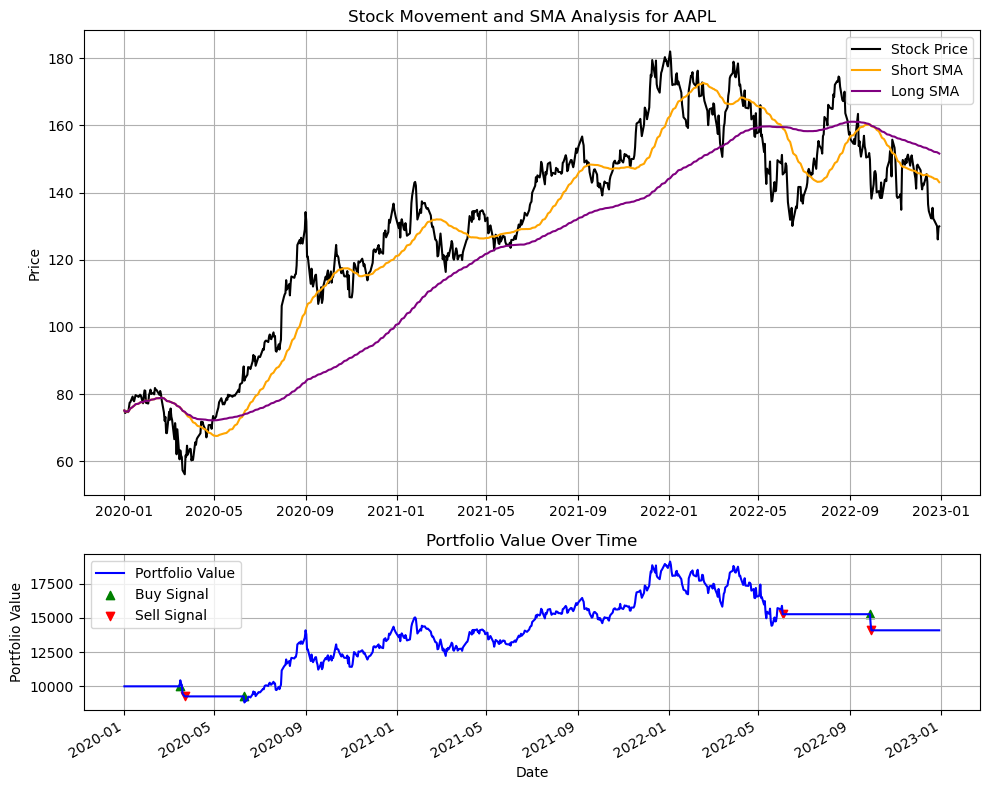

In [10]:
# Main execution
if __name__ == "__main__":
    stock_ticker = input("Enter a stock ticker symbol (e.g., AAPL): ")
    start_date = input("Enter a start date (YYYY-MM-DD): ")
    end_date = input("Enter a end date (YYYY-MM-DD): ")
    initial_cash = float(input("Enter an initial cash balance: "))

    short_sma = input("Enter a short SMA day period (5, 10, 25. The default is 50): ")
    if short_sma == "":
        short_sma = 50
    else:
        short_sma = int(short_sma)

    long_sma = input("Enter a long SMA period (50, 100. The default is 200): ")
    if long_sma == "":
        long_sma = 200
    else:
        long_sma = int(long_sma)

    backtest_sma_strategy(stock_ticker, start_date, end_date, initial_cash, short_sma, long_sma)